In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam


img_width, img_height = 299, 299


epochs = 10
batch_size = 50
num_train_img = 900
num_val_img = 100

base_model = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/train'


train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size)

Found 4480 images belonging to 3 classes.


In [4]:
val_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/test'


val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size)

Found 1170 images belonging to 3 classes.


In [5]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
        
    for fc in fc_layers:
        # new fc layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
        
    # new softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    final_model = Model(inputs=base_model.input, outputs=predictions)
    
    return final_model

classes = ['bed', 'chair', 'sofa']
fc_layers = [1024, 1024]
dropout = 0.3

model = build_final_model(base_model,
                          dropout=dropout,
                          fc_layers=fc_layers,
                          num_classes=len(classes)
                          )

In [6]:
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=epochs, workers=0, 
                                       steps_per_epoch=num_train_img // batch_size, 
                                       shuffle=True, validation_data=val_generator,
                                       validation_steps=num_val_img // batch_size)

Epoch 1/10
18/18 [==============================] - 750s 42s/step - loss: 1.0776 - accuracy: 0.4189 - val_loss: 0.9511 - val_accuracy: 0.6800
Epoch 2/10
18/18 [==============================] - 732s 41s/step - loss: 0.9587 - accuracy: 0.5922 - val_loss: 0.8185 - val_accuracy: 0.7000
Epoch 3/10
18/18 [==============================] - 718s 40s/step - loss: 0.8342 - accuracy: 0.6856 - val_loss: 0.6491 - val_accuracy: 0.9100
Epoch 4/10
18/18 [==============================] - 714s 40s/step - loss: 0.7025 - accuracy: 0.7756 - val_loss: 0.5323 - val_accuracy: 0.8900
Epoch 5/10
18/18 [==============================] - 688s 38s/step - loss: 0.6326 - accuracy: 0.7795 - val_loss: 0.5279 - val_accuracy: 0.8200
Epoch 6/10
18/18 [==============================] - 695s 39s/step - loss: 0.5118 - accuracy: 0.8422 - val_loss: 0.3963 - val_accuracy: 0.9200
Epoch 7/10
18/18 [==============================] - 693s 38s/step - loss: 0.4312 - accuracy: 0.8622 - val_loss: 0.2810 - val_accuracy: 0.9500
Epoch 

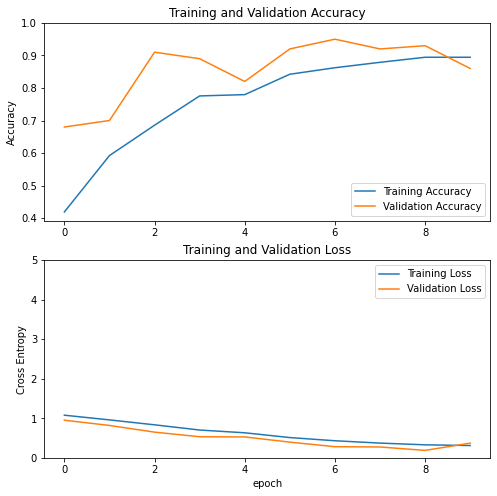

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
# the below path shows the full path for uploaded image, adjust it for your specific path
img_path = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/train/bed/00000002.jpg'

img = image.load_img(img_path, target_size=(img_width, img_height))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data1 = preprocess_input(img_data)

pretrained_feature = model.predict(img_data,verbose=0)
pretrained_feature_np = np.array(pretrained_feature)
pretrained_feature1D = pretrained_feature_np.flatten()

pretrained_feature_base = base_model.predict(img_data1)
pretrained_feature_np_base = np.array(pretrained_feature_base)
pretrained_feature1D_base = pretrained_feature_np_base.flatten()


print (pretrained_feature1D)
y_prob = model.predict(img_data)

y_classes = y_prob.argmax(axis=-1)

print(y_classes)

[0.791357   0.05456683 0.15407613]
[0]


In [9]:
# Below shows the full path for test images, adjust it for your specific path
if y_classes == [0]:
    path = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/test/bed'
elif y_classes == [1]:
    path = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/test/chair'
else:
    path = '/content/gdrive/My Drive/Colab Notebooks/Data/furniture_data/test/sofa'
    
mindist=10000
maxcosine =0
i=0
for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(img_width, img_height))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)

    pretrained_feature_train = base_model.predict(img_data_train)
    pretrained_feature_np_train = np.array(pretrained_feature_train)
    pretrained_feature_train1D = pretrained_feature_np_train.flatten()
    eucldist = dist.euclidean(pretrained_feature1D_base,pretrained_feature_train1D)
    
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
    #print (vgg16_feature_np)
    
    dot_product = np.dot(pretrained_feature1D_base,pretrained_feature_train1D)#normalize the results, to achieve similarity measures independant #of the scale of the vectors
    norm_Y = np.linalg.norm(pretrained_feature1D_base)
    norm_X = np.linalg.norm(pretrained_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    
    
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))

00001153.jpg filename 231.338135 euclediandist 0.479458 cosine_similarity
00001153.jpg minfilename 231.338135 mineuclediandist 00001153.jpg cosfilename 0.479458 maxcosinesimilarity
00000749.jpg filename 193.222137 euclediandist 0.626376 cosine_similarity
00000749.jpg minfilename 193.222137 mineuclediandist 00000749.jpg cosfilename 0.626376 maxcosinesimilarity
00000725.jpg filename 249.744034 euclediandist 0.394293 cosine_similarity
00000749.jpg minfilename 193.222137 mineuclediandist 00000749.jpg cosfilename 0.626376 maxcosinesimilarity
00001172.jpg filename 237.228409 euclediandist 0.451091 cosine_similarity
00000749.jpg minfilename 193.222137 mineuclediandist 00000749.jpg cosfilename 0.626376 maxcosinesimilarity
00001029.jpg filename 272.393127 euclediandist 0.249994 cosine_similarity
00000749.jpg minfilename 193.222137 mineuclediandist 00000749.jpg cosfilename 0.626376 maxcosinesimilarity
00000036.jpg filename 255.179489 euclediandist 0.467492 cosine_similarity
00000749.jpg minfilen

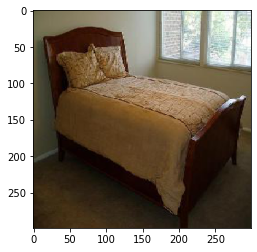

In [10]:
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 0.6391248')

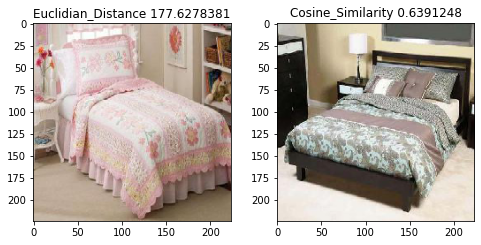

In [11]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Euclidian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))